# Pierwszy i prawdopodobnie ostatni raz w życiu (trenujemy od podstaw konwolucyjną sieć neuronową)

In [1]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey as jkey

from training_cnn import *
from architectures import *

## Dane, dane, me królestwo za dane

***[RAPORT]*** Losowe elementy zbioru treningowego:

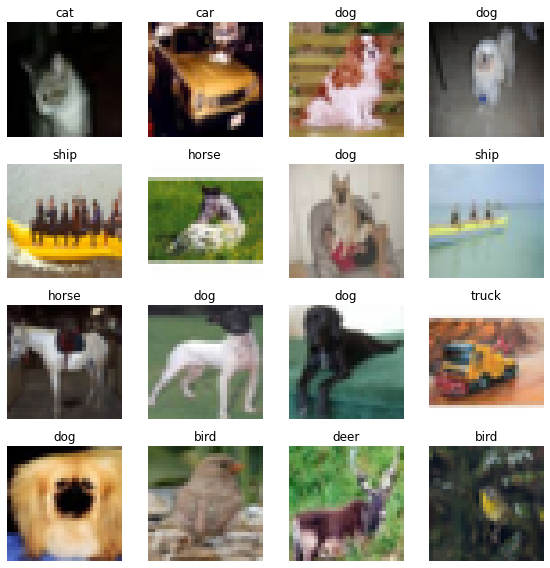

In [2]:
# Loading CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = get_CIFAR10(jkey(42), 0.25)

# Plotting samples
plot_samples(x_train, y_train, (4, 4))

***[RAPORT]*** One hot encoding zrealizowałem z uzyciem funkcji `jax.nn.one_hot()`. Sprawdzam poprawność dla 10 pierwszych etykiet:

In [3]:
y_train_one_hot = jax.nn.one_hot(y_train, 10)
jnp.concatenate((jnp.expand_dims(y_train[:10], axis=-1), y_train_one_hot[:10]), axis=1)

DeviceArray([[3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Minimalna architektura

***[RAPORT]*** Skorzystałem z modułu `flax.linen` (u mnie jako `nn`), co pozwoliło mi na wysokopoziomowe sekwencyjne zdefiniowanie
architektury modelu. Dzięki temu mam dostęp do takich warstw jak `nn.Conv()`, `nn.Dense()`, `nn.max_pool()` oraz funkcji aktywacji
`nn.sigmoid()`, `nn.softmax()`. Mój model `MinCNN` składa się z `2 * (5 * 3 * 3 * 3 + 5) + (4 * 4 * 5 * 10 + 10) = 1090` parametrów.
Specjalnie nie uyłem tutaj na koniec funkcji aktywacji `softmax`, poniewaz kozystam z wbudowanej funkcji kosztu,
`optax.softmax_cross_entropy`, która stosuje softmax na logitach przed wyliczeniem entropii.

```python
class MinCNN(nn.Module):
    
  @nn.compact
  def __call__(self, batch):
    
    batch_size = batch.shape[0]
    x = batch / 255
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.max_pool(x, window_shape=(8, 8), strides=(8, 8))
    x = jnp.reshape(x, (batch_size, -1))
    x = nn.Dense(features=10)(x)
    # x = nn.softmax(x)
      
    return x
```

***[RAPORT]*** Prawdopodobieństwa poszczególnych klas zwracane przez niewytrenowany model dla pierwszych 5 przykładów:

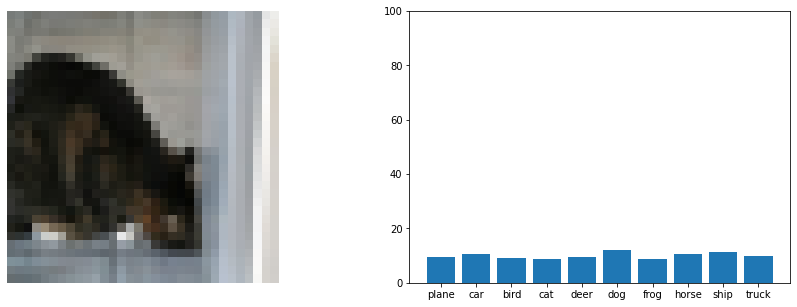

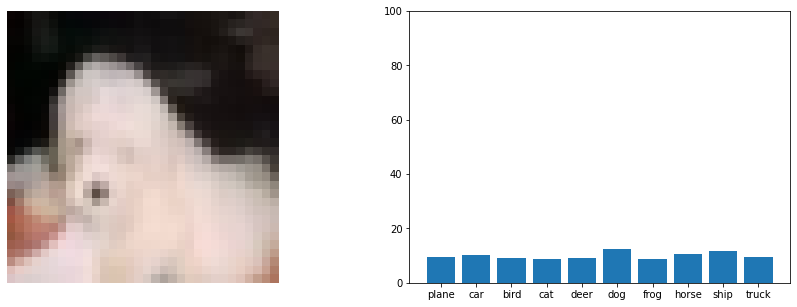

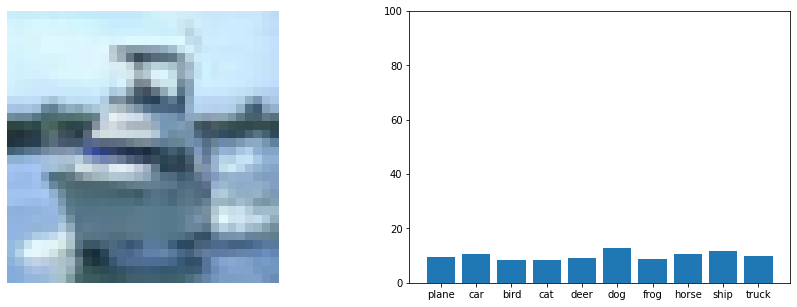

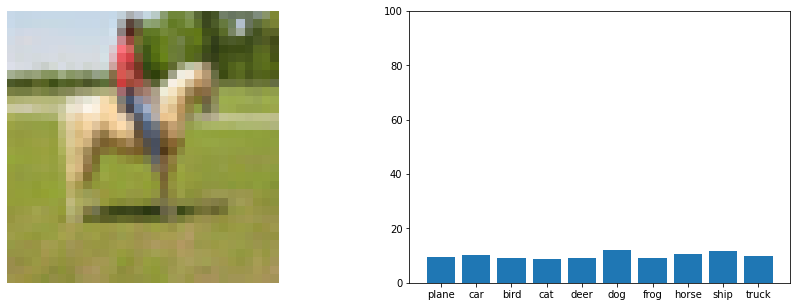

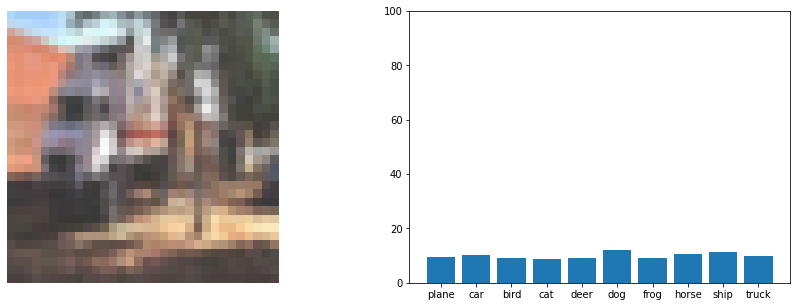

In [6]:
first_n = 5
for i in range(first_n):
    single_prediction(x_train[i], DUMMY_MODEL, verbose=True)

***[RAPORT]*** Przy treningu modelu inspirowałęm się [tutorialem flax](https://flax.readthedocs.io/en/latest/getting_started.html).
Skorzystałem z takich elementów jak `flax.training.train_state.TrainState()` który pozwala w łatwy sposób na funkcyjną implementację
treningu, co jest zgodne z filozofią *JAX*. Jako optymalizatora uzyłem `optax.sgd`. Trening zaimplementowałem w postaci 2 funkcji.
Funkcja `train_and_eval()` iteruje po epokach wywołując funkcję `train_epoch()`, zbiera dane metryki, zapisuje logi i checkpointy.
Z kolei funkcja `train_epoch()` to główna oś treningu i jej kod zamieszczam poniej:

```python
def train_epoch(
	state: TrainState,
	x_train: Array,
	y_train: Array,
	batch_size: int,
	perm_key: PRNGKey
) -> Tuple[TrainState, Scalar, Scalar]:

	n_samples = x_train.shape[0]
	steps_per_epoch = n_samples // batch_size

	perms = jax.random.permutation(perm_key, n_samples)[:steps_per_epoch * batch_size]
	perms = jnp.reshape(perms, (steps_per_epoch, batch_size))

	epoch_loss = []
	epoch_accuracy = []

	for perm in perms:

		x_batch = x_train[perm, ...]
		y_batch = y_train[perm, ...]
		grads, loss, accuracy = apply_model(state, x_batch, y_batch)
		state = update_model(state, grads)
		epoch_loss.append(loss)
		epoch_accuracy.append(accuracy)
	
	return state, np.mean(epoch_loss), np.mean(epoch_accuracy)
```

***[RAPORT]*** Model o minimalnej architekturze wytrenował się w `28m 55.3s`. Ponizej metryki ukazujące przebieg treningu:

![](results/min_cnn/metrices_150.png)

***[RAPORT]*** A tutaj prawdopodobieństwa przynalezności do klas dla pierwszych 5 przykładów według powyzszego modelu:

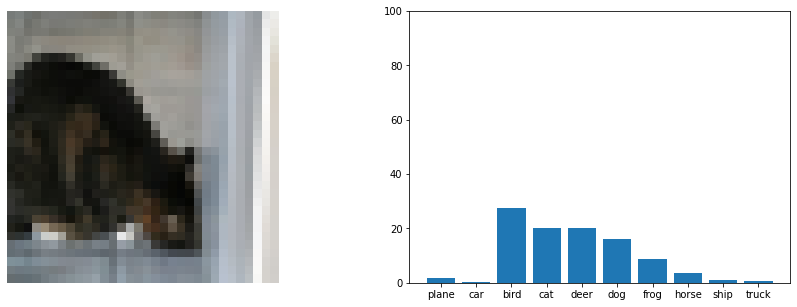

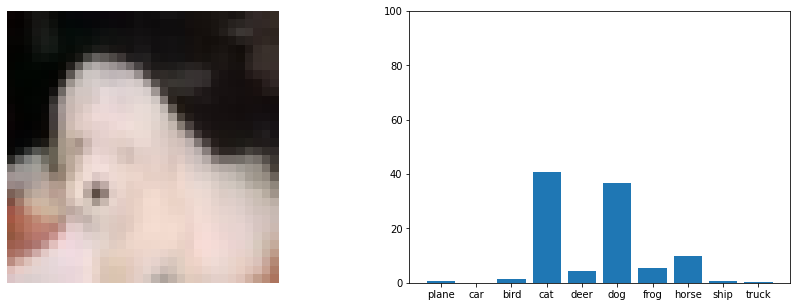

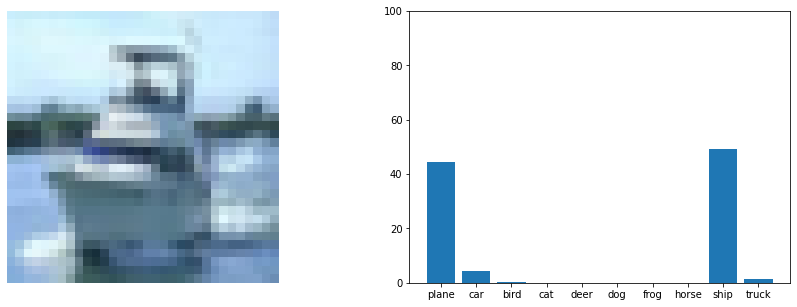

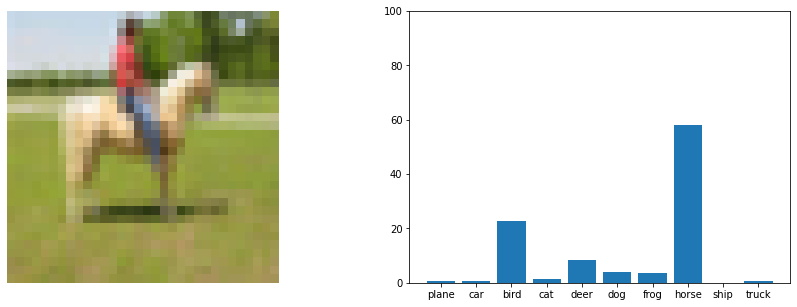

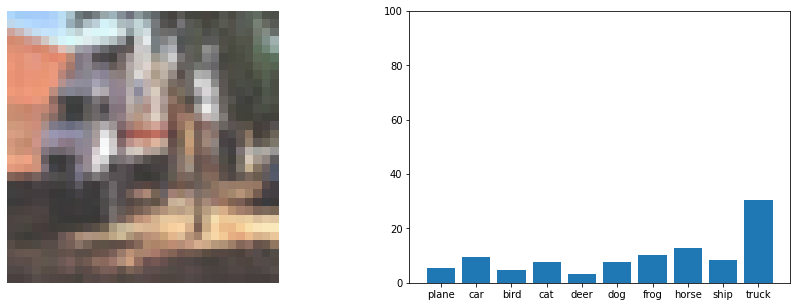

In [7]:
for i in range(first_n):
    single_prediction(x_train[i], MIN_CNN_MODEL, verbose=True)

***[RAPORT]*** Model ze zwiększoną liczbą filtrów z 5 do 20 wytrenował się w `brak danych`*. 
Po 150 epokach osiągneliśmy accuracy ok `60%` z tendencją wzrostową, czyli mozna by było kontynuować trening by uzyskać wyzszy wynik
bez overfitingu. liczba parametrów zwiększyła się 4-krotnie. Ponizej metryki ukazujące przebieg treningu:

![](results/min_cnn_plus/metrices_150.png)

***[RAPORT]*** Blok konwolucyjny z aktywacją relu:
```python
def conv_block(x: Array, features: int) -> Array:

    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    return x
```
***[RAPORT]*** Zmodyfikowany model:
```python
class DoubleBlockCNN(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 20)
        x = conv_block(x, 40)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dense(features=10)(x)
        
        return x
```

***[RAPORT]*** Model dwublokowy wytrenował się w `brak danych`*. 
Po 147** epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `70%`. Wystąpił lekki overfitting, poniewaz loss mocno uciekł do góry,
jednak accuracy nie zmniejszyło się znacząco. (*Loss* na zbiorze walidacyjnym doszedł do wartości ok `3.7`, jednak wartośc nie zmiesciła
sie na wykresie)
Ponizej metryki ukazujące przebieg treningu:

![](results/double_block_cnn/metrices_147.png)